In [100]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [101]:
data = pd.read_excel('./data/index_Infomation.xlsx')
df = data[['Date', 'apple_Close']]

# 전체 데이터 중 80%를 훈련데이터로, 20%를 테스트 데이터로 나누기
df.set_index('Date', inplace=True)  # Date컬럼을 index로 변환
train_size = int(len(df) * 0.8)
train = df['apple_Close'][:train_size]
test = df['apple_Close'][train_size:]

In [ ]:
# Exponential Smoothing 모델 초기화
model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

In [103]:
# 파라미터 옵션 설정

# 트렌드(추세) 요소(trend): 데이터가 장기적인 측면에서 증가하거나 감소하는 모양새를 의미.
# 순환 요소(cycle): 불규칙적이며 반복적인 장기적인 변화 현상을 의미. 급격한 변화가 없다면 지속되는 특징
# 계절 요소(seasonal): 주, 월, 분기, 반기, 1년 등 특정 주기로 반복되는 특징을 의미
# 불규칙 요소(random/residual): 일정한 규칙성을 인지할 수 없는 변동의 유형. 추세, 순환, 계절성을 뺀 나머지

# 'add(덧셈)'옵션: 추세, 순환, 계절, 불규칙의 합. Trend와 Seasonal이 별개
# 'mul(곱셈)'옵션: 추세, 순환, 계절, 불규칙의 곱. 시간이 지남에 따라(Trend가 상승함에 따라) 변동폭이 증가
# 'Damping'옵션, 시간의 경과에 따라 **추세(trend)**가 점차 감소하거나 완화되는 효과.
#  댐핑된 추세는 시간이 지나면서 추세의 기울기가 감소하여 평평해지는 형태를 취함. 추세 성분에 댐핑 계수를 곱하여 점진적으로 그 영향력을 감소
#  이는 현실적으로 많은 경제, 금융, 그리고 자연 현상에서 장기적으로 무한한 성장이나 감소는 없다고 가정할 때 유용

param_grid = {
    'trend': [None, 'add', 'mul'],  # 트렌드(추세) 옵션: 없음, 덧셈적, 곱셈적. 
    'seasonal': [None, 'add', 'mul'],  # 계절성 옵션: 없음, 덧셈적, 곱셈적
    'seasonal_periods': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # 계절성 주기: None ~ 12
    'damped_trend': [True, False],  # 댐핑된 트렌드 사용 여부
}

In [ ]:
# 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))  # test 날짜 만큼 예측 실행
        
        # 평가지표
        mse = mean_squared_error(test, predictions)  # 제곱오차의 평균. 값이 낮을수록 모델의 성능이 좋음. 큰 오차에 대해 더 큰 페널티를 부과
        mae = mean_absolute_error(test, predictions)  # 절대오차의 평균. 오차의 크기를 그대로 반영. 모든 오차를 동일하게 고려
        mape = mean_absolute_percentage_error(test, predictions)  # 값이 낮을수록 예측이 실제 값에 가깝다는 의미. 예측 오차의 백분율을 기준으로 평가. 데이터의 스케일에 영향을 받지 않음
        r2 = r2_score(test, predictions)  # 예측된 값이 실제 값을 얼마나 잘 설명하는지. 1에 가까울수록 모델이 데이터를 잘 설명
        
        # MSE를 기준으로 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

In [105]:
# 결과 출력
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

Best Parameters: {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 12, 'trend': 'mul'}
Best MSE: 160.4392896985213
Best Metrics: {'MSE': 160.4392896985213, 'MAE': 10.2624418709874, 'MAPE': 0.06178195774225986, 'R²': 0.6012046053981406}


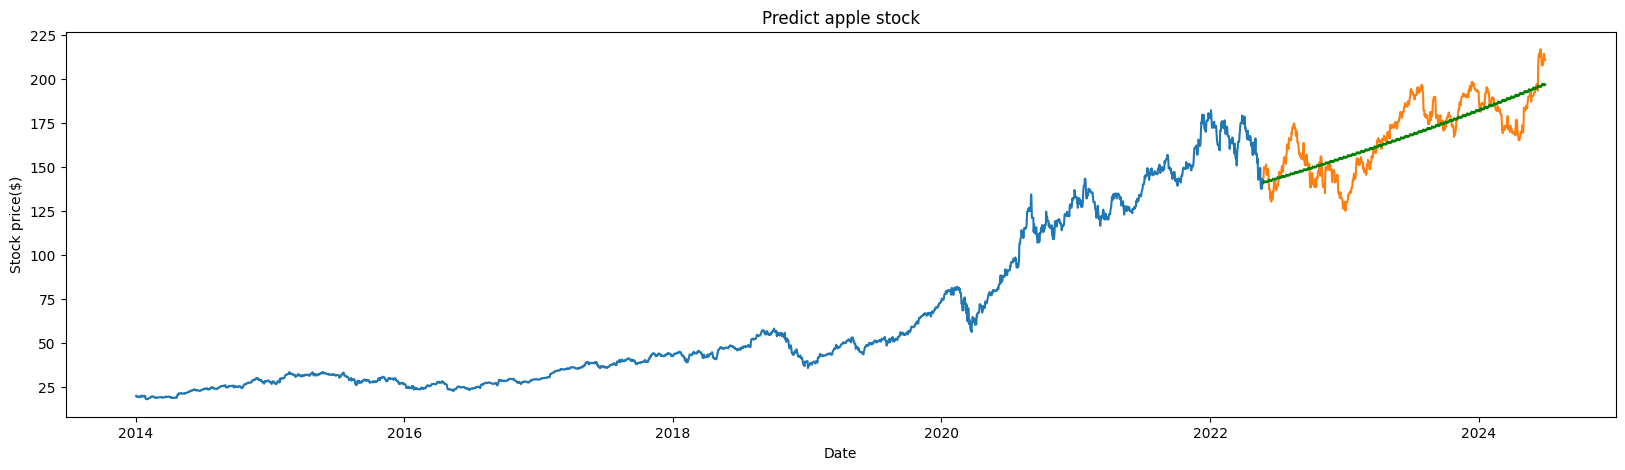

In [106]:
# 최적 모델 예측 시각화

# 인덱스 데이터타입을 date로 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict apple stock')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.show()

In [ ]:
# 축소 학습 예측

# 기간 축소
sort_df = df.loc['2024-01-01' : '2024-06-30']

# 훈련, 테스트 데이터 나누기
train_size = int(len(sort_df) * 0.70)
train = sort_df['apple_Close'][:train_size]
test = sort_df['apple_Close'][train_size:]

# 하이퍼파라미터 옵션
param_grid = {
    'trend': [None, 'add', 'mul'],
    'seasonal': [None, 'add', 'mul'],
    'seasonal_periods': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'damped_trend': [True, False],
}

# 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))
        
        # 평가지표
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        # MSE 값 기준으로 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

In [117]:
# 결과 출력
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

Best Parameters: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': None, 'trend': 'mul'}
Best MSE: 20.897688296750985
Best Metrics: {'MSE': 20.897688296750985, 'MAE': 3.699456091101498, 'MAPE': 0.018382203582775775, 'R²': 0.8216894821186399}


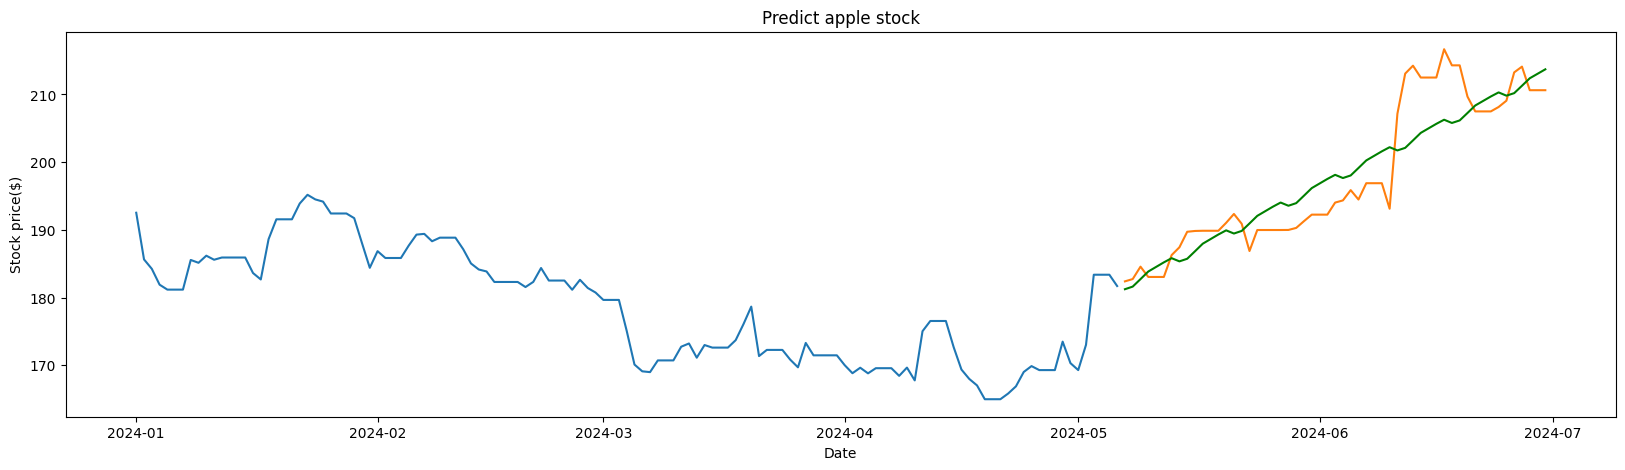

In [118]:
# 최적 모델 예측 시각화

# 인덱스 데이터타입을 date로 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict apple stock')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.show()

In [ ]:
# 단기 다중 예측

# 학습 및 테스트 범위 설정
window_size = 21  # 3주 데이터를 학습 데이터로 사용
test_size = 7  # 1주 데이터를 테스트 데이터로 사용

# 예측 결과를 저장할 데이터프레임 초기화
results_df = pd.DataFrame(columns=['Date', 'Actual', 'Predicted'])

for start in range(0, len(df) - window_size - test_size + 1, test_size):
    train_data = df['apple_Close'][start:start + window_size]
    test_data = df['apple_Close'][start + window_size:start + window_size + test_size]
    
    # 모델 생성 및 학습
    model = ExponentialSmoothing(
        train_data,
        trend=None,
        seasonal=None,
        seasonal_periods=None,
        damped_trend=False
    ).fit()

    # 예측
    prediction = model.forecast(len(test_data))

    # 평가지표
    mse = mean_squared_error(test_data, prediction)
    mae = mean_absolute_error(test_data, prediction)
    mape = mean_absolute_percentage_error(test_data, prediction)
    r2 = r2_score(test_data, prediction)
    
    # 결과를 데이터프레임에 저장
    temp_df = pd.DataFrame({
        'Date': test_data.index,
        'Actual': test_data.values,
        'Predicted': prediction,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    })

    results_df = pd.concat([results_df, temp_df])

In [95]:
print('MSE:', np.mean(results_df['MSE']))
print('MAE:', np.mean(results_df['MAE']))
print('MAPE:', np.mean(results_df['MAPE']))
print('R2:', np.mean(results_df['R²']))

MSE: 10.224692918863163
MAE: 1.9317415413980952
MAPE: 0.022033227321643385
R2: -8.895489514156946


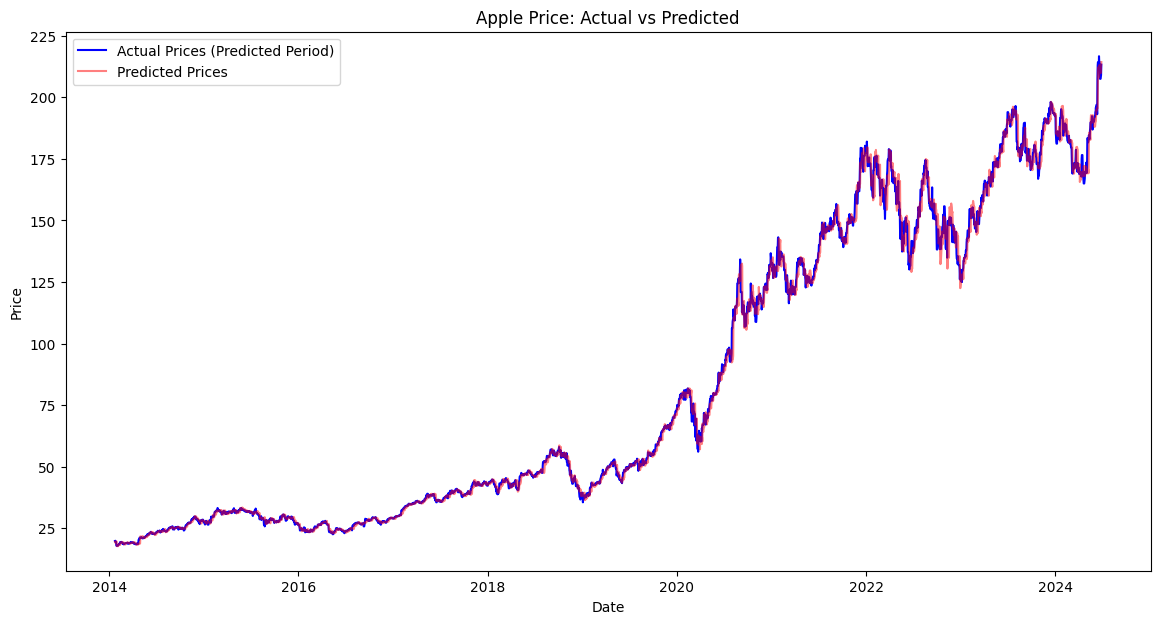

In [96]:
# 단기 예측 시각화

# 인덱스 데이터타입 변경
train_data.index = pd.to_datetime(train_data.index)
test_data.index =  pd.to_datetime(test_data.index)

plt.figure(figsize=(14, 7))

# 실제 전체 주가
# plt.plot(df.index, df['samsung_Close'], label='Actual Prices (Full)', color='blue', linestyle='--')

# 예측 주가 부분만 비교하는 그래프
plt.plot(results_df.index, results_df['Actual'], label='Actual Prices (Predicted Period)', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Prices', color='red', alpha=0.5)

plt.title('Apple Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

In [ ]:
# 모델 저장
with open('pastGraphRegression_apple_exponentialSmoothing.pkl', 'wb') as file:
    pickle.dump(model, file)